# Systemy inspekcji wizualnej  
## Laboratoria  6-8
 
Temat: Segmentacja obrazów kolorowych za pomocą klasteryzacji K-średnich

---  

Nazwisko i Imię: Jakub Grelowski  
Nr albumu: 262754  
data wykonania ćwiczenia: 26.01.2025    

---  

## Wprowadzenie

Celem projektu jest podział obrazów kolorowych na spójne regiony z wykorzystaniem klasteryzacji. Klasteryzacja jest techniką grupowania danych, która w kontekście obrazów pozwala na podział pikseli na grupy o podobnych cechach, takich jak na przykład kolor. W raporcie zostaną omówione techniki segmentacji z wykorzystaniem algorytmów K-średnich oraz C-means na różnych przestrzeniach barw, a także ich efekty na przykładowym obrazie. 

## Implementacja

### Funkcja pomocnicza do wizualizacji obrazów

In [34]:
import matplotlib.pyplot as plt

def plot_images(images, titles, cmap=None):
    plt.figure(figsize=(15, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

### Własna implementacja algorytmu K-średnich

In [35]:
import numpy as np

def kmeans_custom(data, n_clusters, max_iters=100, tol=1e-4):
    np.random.seed(0)
    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, None] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels, centroids

### Przygotowanie danych
Na początku wczytujemy obraz testowy i konwertujemy go z przestrzeni kolorów BGR do RGB. Następnie zmniejszamy obraz, aby przyspieszyć klasteryzację, po czym tworzymy kopie obrazu w przestrzeniach HSV oraz Lab.

In [36]:
import cv2 as cv
im = cv.imread("Lab2zdjecia/PeppersRGB.tif")
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

im_resized = cv.resize(im, (256, 256))
hsv_resized = cv.cvtColor(im_resized, cv.COLOR_RGB2HSV)
lab_resized = cv.cvtColor(im_resized, cv.COLOR_RGB2Lab)

### Klasteryzacja K-średnich

Przekształcamy obraz na przestrzeń cech (wektory pikseli). Każdy piksel traktujemy jako punkt w przestrzeni cech przestrzeni barw. Dane wejściowe są spłaszczone do tablicy 2D, gdzie każdy wiersz reprezentuje piksel.


In [37]:
data_rgb = im_resized.reshape((-1, 3))
data_hsv = hsv_resized.reshape((-1, 3))
data_lab = lab_resized.reshape((-1, 3))

Algorytm K-średnich grupuje dane w określoną liczbę klastrów (*n_clusters*).
Każdy piksel jest przypisany do najbliższego centrum klastra.

In [38]:
from sklearn.cluster import KMeans
from time import time

kmeans_rgb = KMeans(n_clusters=3, random_state=0)
kmeans_hsv = KMeans(n_clusters=3, random_state=0)
kmeans_lab = KMeans(n_clusters=3, random_state=0)


start = time()
predictions_rgb = kmeans_rgb.fit_predict(data_rgb)
sklearn_time = time() - start

predictions_hsv = kmeans_hsv.fit_predict(data_hsv)
predictions_lab = kmeans_lab.fit_predict(data_lab)

Rekonstrukcja obrazu po klasteryzacji: każdy piksel obrazu przyjmuje kolor swojego klastra

In [39]:
kmeans_segmented_rgb = predictions_rgb.reshape(im_resized.shape[:2])
kmeans_segmented_hsv = predictions_hsv.reshape(hsv_resized.shape[:2])
kmeans_segmented_lab = predictions_lab.reshape(lab_resized.shape[:2])

Kolorowanie segmentów dla wizualizacji. Wykorzystujemy centra klastrów, aby nadać każdemu klastrowi odrębny kolor

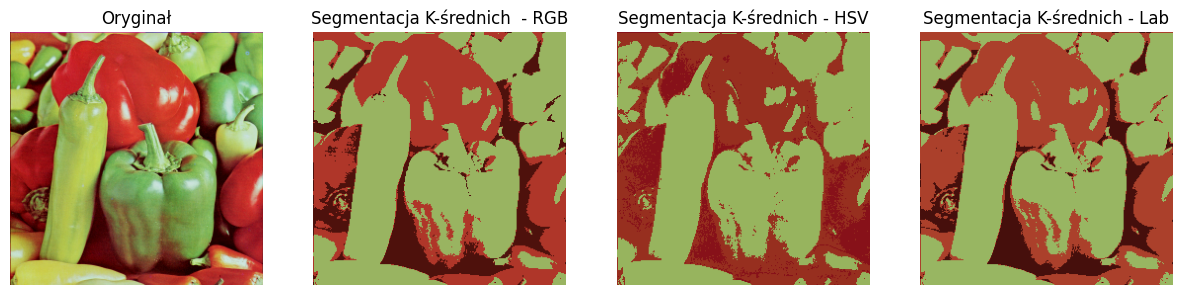

In [40]:
kmeans_colored_rgb = np.zeros_like(im_resized)
kmeans_colored_hsv = np.zeros_like(hsv_resized)
kmeans_colored_lab = np.zeros_like(lab_resized)

colors_rgb = kmeans_rgb.cluster_centers_.astype(int)
colors_hsv = kmeans_hsv.cluster_centers_.astype(int)
colors_lab = kmeans_lab.cluster_centers_.astype(int)

for i in range(3):
    kmeans_colored_rgb[kmeans_segmented_rgb == i] = colors_rgb[i]
    kmeans_colored_hsv[kmeans_segmented_hsv == i] = cv.cvtColor(np.uint8([[colors_hsv[i]]]), cv.COLOR_HSV2RGB).squeeze()
    kmeans_colored_lab[kmeans_segmented_lab == i] = cv.cvtColor(np.uint8([[colors_lab[i]]]), cv.COLOR_Lab2RGB).squeeze()

plot_images([im_resized, kmeans_colored_rgb, kmeans_colored_hsv, kmeans_colored_lab],
            ["Oryginał", "Segmentacja K-średnich  - RGB", "Segmentacja K-średnich - HSV", "Segmentacja K-średnich - Lab"])


### Własna implementacja K-średnich

                     Algorytm  Czas wykonania
0  Implementacja scikit-learn        0.021027
1        Własna implementacja        0.214725


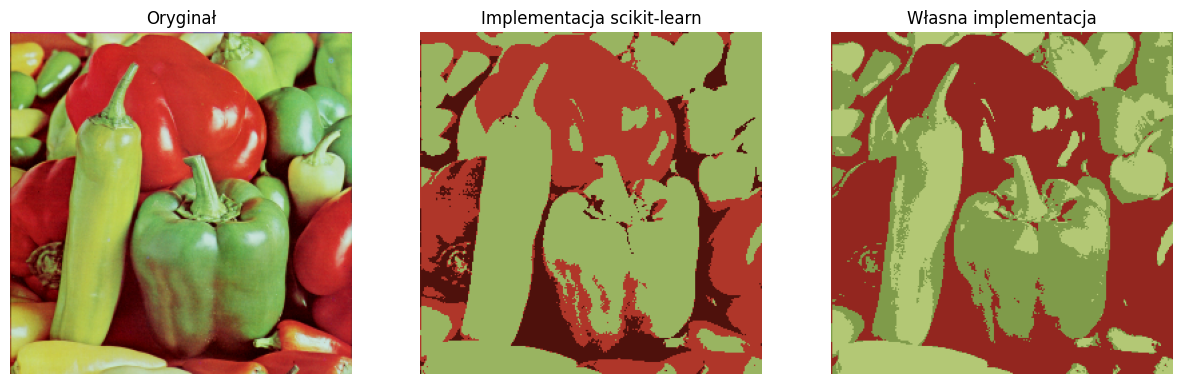

In [41]:
import pandas as pd

start = time()
kmeans_custom_labels, kmeans_custom_centroids = kmeans_custom(data_rgb, 3, max_iters=300)
custom_time = time() - start
kmeans_custom_segmented = kmeans_custom_labels.reshape(im_resized.shape[:2])
kmeans_custom_colored = np.zeros_like(im_resized)

for i in range(3):
    kmeans_custom_colored[kmeans_custom_segmented == i] = kmeans_custom_centroids[i]


data = [["Implementacja scikit-learn", sklearn_time], 
        ["Własna implementacja", custom_time]]

df = pd.DataFrame(data, columns=["Algorytm", "Czas wykonania"])

print(df)

plot_images([im_resized, kmeans_colored_rgb, kmeans_custom_colored], 
            ["Oryginał", "Implementacja scikit-learn", "Własna implementacja"])


### Klasteryzacja C-means
Algorytm C-means przypisuje piksele do klastrów z pewnym stopniem przynależności (*fuzzy clustering*), co pozwala na bardziej elastyczne podziały.

In [42]:
from fcmeans import FCM

fcm_rgb = FCM(n_clusters=3)
fcm_hsv = FCM(n_clusters=3)
fcm_lab = FCM(n_clusters=3)

fcm_rgb.fit(data_rgb)
fcm_hsv.fit(data_hsv)
fcm_lab.fit(data_lab)

labels_rgb = fcm_rgb.u.argmax(axis=1)
labels_hsv = fcm_hsv.u.argmax(axis=1)
labels_lab = fcm_lab.u.argmax(axis=1)


Rekonstrukcja obrazu po klasteryzacji

In [43]:
fcm_segmented_rgb = labels_rgb.reshape(im_resized.shape[:2])
fcm_segmented_hsv = labels_hsv.reshape(hsv_resized.shape[:2])
fcm_segmented_lab = labels_lab.reshape(lab_resized.shape[:2])

Kolorowanie segmentów dla wizualizacji

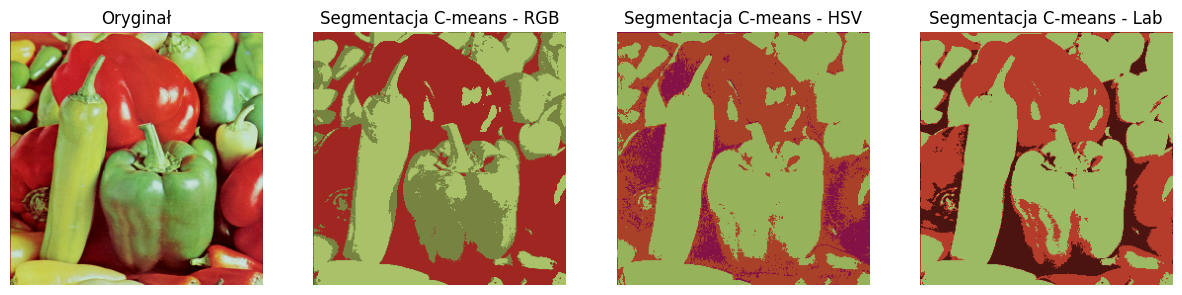

In [44]:
fcm_colored_rgb = np.zeros_like(im_resized)
fcm_colored_hsv = np.zeros_like(hsv_resized)
fcm_colored_lab = np.zeros_like(lab_resized)

for i in range(3):
    fcm_colored_rgb[fcm_segmented_rgb == i] = fcm_rgb.centers[i]
    fcm_colored_hsv[fcm_segmented_hsv == i] = cv.cvtColor(np.uint8([[fcm_hsv.centers[i]]]), cv.COLOR_HSV2RGB).squeeze()
    fcm_colored_lab[fcm_segmented_lab == i] = cv.cvtColor(np.uint8([[fcm_lab.centers[i]]]), cv.COLOR_Lab2RGB).squeeze()

plot_images([im_resized, fcm_colored_rgb, fcm_colored_hsv, fcm_colored_lab], ["Oryginał" ,"Segmentacja C-means - RGB", "Segmentacja C-means - HSV", "Segmentacja C-means - Lab"])

## Analiza wyników

### Wpływ przestrzenii barw na segmentację  

#### Segmentacja w przestrzeni RGB
RGB, jako podstawowa przestrzeń barw, pozwala na segmentację obrazów w ich natywnych wartościach kolorystycznych.  
W obu algorytmach segmentacja w RGB daje wyniki z dobrze zdefiniowanymi klastrami, szczególnie widoczne w wyrazistych barwach, takich jak czerwony i zielony. Jednak RGB jest skuteczne w oddzielaniu podobnych kolorów o różnych odcieniach lub jasności.

#### Segmentacja w przestrzeni HSV
Przestrzeń HSV oddziela barwę od jasności i nasycenia, co często lepiej odpowiada ludzkiej percepcji kolorów.  
Wyniki pokazują większe różnice w segmencie jasności, ale algorytmy mogą być bardziej wrażliwe na różnice w cieniach, co czasami prowadzi do większego szumu w segmentacji. W porównaniu do RGB, HSV może lepiej rozdzielić podobne kolory, jednak czasami trudniej jest uzyskać jednoznaczne klastry dla subtelnych przejść barw.    

#### Segmentacja w przestrzeni Lab
Przestrzeń Lab rozdziela jasność od koloru w sposób bardziej precyzyjny niż HSV, co pozwala na lepszą separację obiektów o podobnych kolorach, ale różnej jasności.  
Wyniki w Lab są bardziej jednorodne, zwłaszcza w przypadku segmentacji tła i obiektów. Algorytmy segmentacji w tej przestrzeni są bardziej stabilne w przypadku obrazów o złożonej strukturze kolorów.   

### Porównanie własnej implementacji z scikit-learn

Implementacja K-średnich z OpenCV działa znacznie szybciej niż własna implementacja, co wynika z optymalizacji biblioteki OpenCV oraz wykorzystania dedykowanych struktur danych i operacji macierzowych.
Własna implementacja jest prawie 10 razy wolniejsza, co może stanowić problem przy przetwarzaniu większych obrazów.  

Widoczne są różnice w przypisaniu kolorów do poszczególnych klastrów – własna implementacja przypisuje bardziej nasycone barwy.  
OpenCV zapewnia bardziej jednolitą segmentację, podczas gdy własna implementacja tworzy bardziej chaotyczne regiony – co może wynikać z różnic w inicjalizacji centroidów oraz procesu iteracyjnego.  

### Porównianie algorytmów segmentacji

K-średnich tworzy wyraźne granice między klastrami, co może być korzystne w przypadku dobrze zdefiniowanych kolorów, ale mniej elastyczne w przypadku obrazów z bardziej rozmytymi przejściami barw.   
C-means pozwala na stopniową przynależność pikseli do różnych klastrów, co skutkuje bardziej subtelnymi segmentacjami. Może być użyteczne w obrazach z dużą ilością detali i różnorodnością kolorów, ale czasami daje bardziej rozmyte wyniki.